# JAX / NumPyro tutorial

- What is JAX?

- JAX basics

- Things no one tells you

- Sampling using NumPyro HMC and JAX

### NVIDIA stock
<img src="nvidia.png" alt="" style="">

## What is JAX?

JAX is a Python library for array-oriented numerical computation.

- NumPy-like interface which runs on CPU, GPU, or TPU.
- Features Just-In-Time (JIT) compilation
- Automatic vectorization.
- Automatic differentiation of functions.

## JAX basics

In [1]:
# Run this if you've never used JAX or NumPyro.

# !pip install numpyro
# !pip install jax
# !pip install corner

In [2]:
import jax
import jax.numpy as jnp
import jax.scipy as js
import jax.random as jr

# for comparison
import numpy as np
import scipy

# for sampling later
import numpyro
import numpyro.distributions as dist
numpyro.set_host_device_count(10)

# plotting packages
import corner
import matplotlib.pyplot as plt
# plt.style.use('dark_background')

### Single-precision

In [3]:
# by default JAX uses single-precision (float32)
jax.config.update('jax_enable_x64', True)
print(np.cos(np.pi / 3))
print(jnp.cos(jnp.pi / 3))

0.5000000000000001
0.5000000000000001


### NumPy-like arrays

In [4]:
numpy_array = np.array([4.3, -7.3, 0.001])
jax_array = jnp.array([4.3, -7.3, 0.001])
print(type(numpy_array))
print(type(jax_array))

<class 'numpy.ndarray'>
<class 'jaxlib.xla_extension.ArrayImpl'>


In [5]:
print(type(np.array(jax_array)))
print(type(jnp.array(numpy_array)))

<class 'numpy.ndarray'>
<class 'jaxlib.xla_extension.ArrayImpl'>


In [6]:
array1 = jnp.array([1., -2.5, 0.6])
array2 = jnp.array([5.3, 5.002, -11.5])
array1 + array2

Array([  6.3  ,   2.502, -10.9  ], dtype=float64)

In [7]:
jnp.inner(array1, array2)

Array(-14.105, dtype=float64)

In [8]:
jnp.outer(array1, array2)

Array([[  5.3   ,   5.002 , -11.5   ],
       [-13.25  , -12.505 ,  28.75  ],
       [  3.18  ,   3.0012,  -6.9   ]], dtype=float64)

In [9]:
jnp.linalg.eig(jnp.outer(array1, array2))

(Array([-1.41050000e+01+0.j,  1.89565272e-15+0.j, -4.92553739e-16+0.j],      dtype=complex128),
 Array([[ 0.36249972+0.j, -0.64427471+0.j,  0.69500469+0.j],
        [-0.90624929+0.j,  0.76397584+0.j,  0.48465486+0.j],
        [ 0.21749983+0.j,  0.03536967+0.j,  0.5311103 +0.j]],      dtype=complex128))

In [10]:
# other common arrays
a = jnp.zeros((3, 3))       # 2D array of zeros
b = jnp.ones((3, 3, 5))     # 3D array of ones
c = jnp.arange(0, 10, 2)    # [0, 2, 4, 6, 8]
d = jnp.linspace(0, 1, 5)   # [0., 0.25, 0.5, 0.75, 1.]
e = jnp.eye(4)              # 4x4 identity matrix

In [11]:
# array slicing
b[3, 1]
c[0:4]

Array([0, 2, 4, 6], dtype=int64)

In [12]:
# broadcasting
f = (a[..., None] * b)[..., None] / jnp.outer(c, d)
print(f.shape)

(3, 3, 5, 5)


In [13]:
# jax.random uses PRNG keys
random_seed = 150914
a_PRNG_key = jr.key(random_seed)
random_numbers = jr.normal(key=a_PRNG_key, shape=(100, 100))

# need many PRNG keys?
many_PRNG_keys = jr.split(key=a_PRNG_key, num=50)

### Some things are different...

In [14]:
# JAX arrays are expensive to create!!!
%timeit np.array([5, 5, 5])
%timeit jnp.array([5, 5, 5])

179 ns ± 1.73 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
17.8 µs ± 132 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [15]:
# Can you modify JAX arrays? No!

numpy_array = np.array([0, 1, 2, 3, 4, 5])
jax_array = jnp.array([0, 1, 2, 3, 4, 5])

numpy_array[3] = 0
print(numpy_array)

# jax_array[3] = 0    # error!
jax_array = jax_array.at[3].set(0)
print(jax_array)

# # also try...
# numpy_array[2] += 1
# # jax_array[2] += 1   # error!
# jax_array = jax_array.at[2].add(1)

[0 1 2 0 4 5]
[0 1 2 0 4 5]


In [16]:
%timeit numpy_array[3] = 0
%timeit jax_array.at[3].set(0)

29.6 ns ± 0.256 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
119 µs ± 971 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [17]:
# Can we speed up JAX array modification?
arr = jnp.arange(10, dtype=jnp.float32)
zeros = jnp.zeros(5, dtype=jnp.float32)
%timeit arr.at[-5:10].set(0.)
%timeit jnp.concatenate((arr[:-5], zeros), axis=0)

139 µs ± 2.55 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
35.6 µs ± 418 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Takeaways:

- JAX arrays operate similar to NumPy arrays.
- JAX arrays are expensive to create and modify!

## Just-In-Time (JIT) compilation

Suppose we have the function $f: \mathbb{R}^2 \rightarrow \mathbb{R}$,

\begin{equation*}
    f(x, y) = \text{Tr}\big[(\mathbf{A} + x\mathbf{I})^\text{T}\,(\mathbf{A} + y\mathbf{I})^3\big]\,,
\end{equation*}

where $\mathbf{A}$ is a constant matrix and $\mathbf{I}$ is the identity.

In [18]:
def numpy_func(x, y, A):
    M = (A + x * np.eye(A.shape[0])).T @ (A + y * np.eye(A.shape[0]))**3
    return np.trace(M)

def jax_func(x, y, A):
    M = (A + x * jnp.eye(A.shape[0])).T @ (A + y * jnp.eye(A.shape[0]))**3
    return jnp.trace(M)

# some inputs
x = 2.5
y = -3.9
jax_A = jr.normal(jr.key(200129), (100, 100))
numpy_A = np.array(jax_A)

print(numpy_func(x, y, numpy_A))
print(jax_func(x, y, jax_A))

16195.1558789598
16195.155878959802


In [19]:
%timeit numpy_func(x, y, numpy_A)
%timeit jax_func(x, y, jax_A)

237 µs ± 54.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
305 µs ± 4.44 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [20]:
# JIT JAX likelihood
fast_jax_func = jax.jit(jax_func)

# test
print(fast_jax_func(x, y, jax_A))

16195.155878959802


In [21]:
%timeit fast_jax_func(x, y, jax_A)

62.3 µs ± 633 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Can you JIT everything? No...

In [23]:
# return True if even, False if odd
def is_even(integer):
    if integer % 2 == 0:  # even
        return True
    else:  # odd
        return False
    
fast_is_even = jax.jit(is_even)

# print(is_even(6))
# print(fast_is_even(6))    # error!

In [26]:
# conditionals work-around
def spit_True():
    return True

def spit_False():
    return False

def is_even_redo(integer):
    even = (integer % 2 == 0)
    return jax.lax.cond(even, spit_True, spit_False)

fast_is_even_redo = jax.jit(is_even_redo)
print(fast_is_even_redo(7))

False


In [27]:
%timeit is_even(6)
%timeit fast_is_even_redo(6)

27.1 ns ± 0.284 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
3.64 µs ± 85.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


#### Takeaways:

- JIT compile expensive functions which are called many times (e.g. likelihood evaluations)
- You can't JIT compile anything...

## Automatic vectorization

In [28]:
# suppose we want to evaluate the function over many inputs
num_evaluations = 100
many_x = jr.normal(jr.key(230814), (num_evaluations,))
many_y = jr.normal(jr.key(250114), (num_evaluations,))
jax_A = jr.normal(jr.key(170817), (10, 10))

In [29]:
%timeit [fast_jax_func(x, y, jax_A) for x, y in zip(many_x, many_y)]

1.3 ms ± 51.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [30]:
# we can automatically vectorize JAX functions
vectorized_jax_func = jax.jit(jax.vmap(fast_jax_func, in_axes=(0, 0, None)))

# test
print(vectorized_jax_func(many_x, many_y, jax_A))

[238.16253121 410.84538033 237.8262479  193.13277777 188.71385473
 231.22452905 187.52344914 185.75143569 189.93176118 189.76782109
 271.14591902 206.69822018 203.31794159 274.15944343 375.37014889
 213.68779701 251.80131385 191.78809736 192.80596995 189.68665691
 246.51574574 199.60538296 194.96384898 169.62060145 192.75615491
 178.3154067  196.03076594 278.60173332 209.00177647 207.81722471
 194.89719226 224.44636745 193.19709623 202.08318064 188.8458363
 151.88399817 169.52652916 185.29803409 289.05336112 190.93582726
 228.57001717 447.75521405 206.6370806  201.55543482 236.20807378
 270.71962514 224.75210851  83.13816038 187.82989419 184.75116572
 226.29517297 189.96613794 185.73072159 229.33678633 226.13192042
 366.27525622 190.06364384 250.74753425 209.03491917 203.52956707
 295.81909784 201.07494907 179.05294276 242.53560217 196.27110364
 186.34340856 190.64075157 187.61979681 196.84423017 190.25716465
 343.30375077 165.09943741 314.41467576 365.26492323 189.10825648
 166.112809

In [31]:
%timeit vectorized_jax_func(many_x, many_y, jax_A)

40.1 µs ± 210 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Automatic differentiation

Suppose $f(x) = x\cos(3x),\hspace{1.5mm} g(x) = e^{x^2}\,\ln(x), \hspace{1.5mm}\text{and}\hspace{1.5mm} h(x) = \cos(x)e^{\tan(x)}$. The $\textit{analytic}$ derivative of the product,

\begin{equation*}
    \frac{d}{dx}\bigg[f(x)\,g(x)\,h(x)\bigg] = f'\, g\, h + f\, g'\, h + f\, g\, h'\,,
\end{equation*}

grows geometrically due to the product and chain rule.

Numerical derivatives, like finite differencing, are computationally expensive in high-dimensions, and must be tuned to be numerically stable.

Automatic differentiation computes derivatives with directed acyclic graphs (DAGs). This is $\textit{fast}$ and $\textit{exact}$, even for high-dimensional functions. Consider the example function,

\begin{equation*}
    f(x_1, x_2) = x_1 \,\text{exp}\bigg[-\frac{1}{2}(x_1^2 + x_2^2)\bigg]\,.
\end{equation*}

<img src="graph.png">

In [32]:
# we can take derivatives of JAX functions
grad_jax_func = jax.jit(jax.grad(fast_jax_func, argnums=(0, 1)))

# test
print(grad_jax_func(x, y, jax_A))

(Array(-712.51617912, dtype=float64, weak_type=True), Array(971.38475443, dtype=float64, weak_type=True))


In [33]:
%timeit fast_jax_func(x, y, jax_A)
%timeit grad_jax_func(x, y, jax_A)

11.3 µs ± 818 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
18.4 µs ± 714 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [34]:
# try these
# jax.hessian
# jax.jacobian
# jax.jit(jax.vmap(jax.hessian(...)))

## Best practices

- Initialize and store as many jax.arrays as possible at the start of your code. Avoid creating/modifying jax.arrays in code which is executed many times.

- JIT compile functions.

- Compose auto-diff, auto-vec, and JIT wrappers.

- Break up your code into JAX blocks, and non-JAX blocks. Use JAX for heavy repeated computations (e.g. likelihood evaluations), NumPy for bookkeeping (e.g. modifying chains).

- It’s easier to start a project in JAX from the beginning than to add it later.

## Sampling with HMC in NumPyro

For a target density, $\pi(\mathbf{q})$, from which we want to sample, Hamiltonian Monte Carlo (HMC) defines a Hamiltonian,

\begin{align*}
    H(\mathbf{q}, \mathbf{p}) &= T(\mathbf{p}) + V(\mathbf{q}) \\
    &= T(\mathbf{p}) - \ln\pi(\mathbf{q})\,.
\end{align*}

If we start from a sample $\mathbf{q}_0$ (and randomized initial momentum $\mathbf{p}_0$), subsequent samples are proposed by integrating Hamilton's equations,

\begin{align*}
    \dot{q}_i = &\frac{\partial H}{\partial p_i} \\
    \dot{p}_i = -&\frac{\partial H}{\partial q_i}
\end{align*}

for some period of time. After integrating for some time to points $(\mathbf{q}_\text{final}, \mathbf{p}_\text{final})$, the acceptance probability is,

\begin{equation*}
    \alpha = \text{min}\bigg(1,\,\frac{\text{exp}[-H(\mathbf{q}_\text{final}, \mathbf{p}_\text{final})]}{\text{exp}[-H(\mathbf{q}_0, \mathbf{p}_0)]}\bigg)\,.
\end{equation*}

#### Pros
- Scales very well with high-dimension (easily samples 1000s of dimensions)
- Finds a (local) peak very quickly
- Long jump proposals, i.e. low auto-correlation in chain

#### Cons
- Need partial derivatives of target density (not a con if you're using JAX)
- Struggles with multi-modal distributions
- Difficult to mix in other proposals in current implementations


Animation of HMC: https://chi-feng.github.io/mcmc-demo/app.html

Start by defining a likelihood in JAX.

In [35]:
jax.config.update('jax_enable_x64', False)

In [36]:
r_unit = 1.
def ring_lnlike(x, y):
    r = jnp.sqrt(x**2 + y**2)
    return -5. * (r - r_unit)**2

vectorized_ring_lnlike = jax.vmap(ring_lnlike, in_axes=(0, 0))

def mobius_ladder_lnlike(xs, coupling_weights):
    n = xs.shape[0]

    # rails of ladder
    rail_terms = vectorized_ring_lnlike(xs, jnp.roll(xs, 1)) + vectorized_ring_lnlike(xs, jnp.roll(xs, -1))

    # rungs of ladder
    rung_terms = vectorized_ring_lnlike(xs, jnp.roll(xs, n // 2))
    
    total_lnlike_val = jnp.sum((rail_terms - 0.1 * rung_terms) * coupling_weights)
    return total_lnlike_val

fast_mobius_ladder_lnlike = jax.jit(mobius_ladder_lnlike)

In [37]:
# application of auto-differentiation
example_x_input = jr.normal(jr.key(190521), (1000,))
example_coupling_weights = jnp.ones_like(example_x_input)

grad_mobius_ladder_lnlike = jax.jit(jax.grad(fast_mobius_ladder_lnlike, argnums=(0)))
print(grad_mobius_ladder_lnlike(example_x_input, example_coupling_weights))

[ 1.74544239e+01  4.84919101e-01  2.36295338e+01 -8.32346916e+00
  6.11235082e-01 -1.20439177e+01  1.71417675e+01  6.26686211e+01
 -1.55955000e+01 -1.62795532e+00  1.07551355e+01  2.81154346e+01
  1.31719265e+01 -1.16646385e+00 -1.03824148e+01 -1.00523639e+00
 -1.48594255e+01  9.95731533e-01  2.94920540e+00  5.12241507e+00
 -2.86592846e+01  1.09462881e+01  7.36028612e-01  6.87140077e-02
 -1.07533875e+01  2.45267982e+01 -3.02293129e+01 -2.49483109e+01
 -1.28178720e+01  1.75896378e+01  1.18706095e+00  1.34606762e+01
 -5.23828650e+00  1.12126303e+01 -7.64797831e+00  3.19295168e+00
  3.41477203e+00  1.13110895e+01  3.79099083e+01 -1.08269639e-01
  1.30111322e-01 -2.94685230e+01 -1.88847408e+01  1.13584292e+00
 -4.43640137e+00  8.20669556e+00  5.64963007e+00 -4.49344873e+00
  6.87498140e+00  2.44818240e-01 -2.05022168e+00 -1.85264528e+00
 -4.90635014e+00  1.13653004e+00  2.02590446e+01  4.68182325e+00
  3.21700592e+01  1.92966709e+01  2.84164925e+01 -3.04161787e+00
 -4.32690948e-01 -2.53054

In [38]:
%timeit fast_mobius_ladder_lnlike(example_x_input, example_coupling_weights)

8.61 µs ± 1.16 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [39]:
%timeit grad_mobius_ladder_lnlike(example_x_input, example_coupling_weights)

10.8 µs ± 262 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [40]:
get_negative_Fisher = jax.jit(jax.hessian(fast_mobius_ladder_lnlike, argnums=(0)))
print(get_negative_Fisher(example_x_input, example_coupling_weights))

[[-11.739878    5.996847    0.        ...   0.          0.
  -19.620274 ]
 [  5.996847  -27.557468   -4.7203174 ...   0.          0.
    0.       ]
 [  0.         -4.7203164 -32.49636   ...   0.          0.
    0.       ]
 ...
 [  0.          0.          0.        ... -24.02422     9.164368
    0.       ]
 [  0.          0.          0.        ...   9.164367  -30.870518
    0.809139 ]
 [-19.620275    0.          0.        ...   0.          0.8091391
  101.221436 ]]


A fun hierarchical model,

\begin{equation*}
    p(\mathbf{x}, \sigma, k | d) \propto p(d | \mathbf{x}) \cdot p(\mathbf{x} | \sigma) \cdot p(\sigma | k) \cdot p(k)\,,
\end{equation*}

where

\begin{align*}
    d | \mathbf{x} \,\sim & \,\text{``sum of rings (whose covariance is topologically a M\"{o}bius ladder)"} \\
    \mathbf{x} | \sigma \,\sim & \,\mathcal{N}(0, \sigma^2) \\
    \sigma | k \,\sim & \,\chi^2(k) \\
    k \,\sim & \,\text{Uniform(0, 100)}\,. \\
\end{align*}

In [41]:
# NumPyro sampling model
def model(ndim, coupling_weights):
    
    # hyper-hyper-prior
    k = numpyro.sample('k', dist.Uniform(0., 100.))

    # hyper-prior
    sigma = numpyro.sample('sigma', dist.Chi2(k))

    # prior
    x = numpyro.sample('x', dist.Normal(0., sigma).expand((ndim,)))

    # likelihood
    numpyro.factor('lnlike', fast_mobius_ladder_lnlike(x, coupling_weights))

In [42]:
# define No U-Turn Sampling kernel
nuts_kernel = numpyro.infer.NUTS(model=model)

# set-up MCMC
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(5e3),
                          num_samples=int(1e5),
                          num_chains=10)

# run MCMC
ndim = 8
# ndim = 100  # try this...
coupling_weights = 3.5 * jnp.sin(jnp.pi * np.arange(ndim) / ndim)
mcmc.run(jr.key(170817), ndim, coupling_weights)

# save chain
samples = mcmc.get_samples()

  0%|          | 0/105000 [00:00<?, ?it/s]

  0%|          | 0/105000 [00:00<?, ?it/s]

  0%|          | 0/105000 [00:00<?, ?it/s]

  0%|          | 0/105000 [00:00<?, ?it/s]

  0%|          | 0/105000 [00:00<?, ?it/s]

  0%|          | 0/105000 [00:00<?, ?it/s]

  0%|          | 0/105000 [00:00<?, ?it/s]

  0%|          | 0/105000 [00:00<?, ?it/s]

  0%|          | 0/105000 [00:00<?, ?it/s]

  0%|          | 0/105000 [00:00<?, ?it/s]

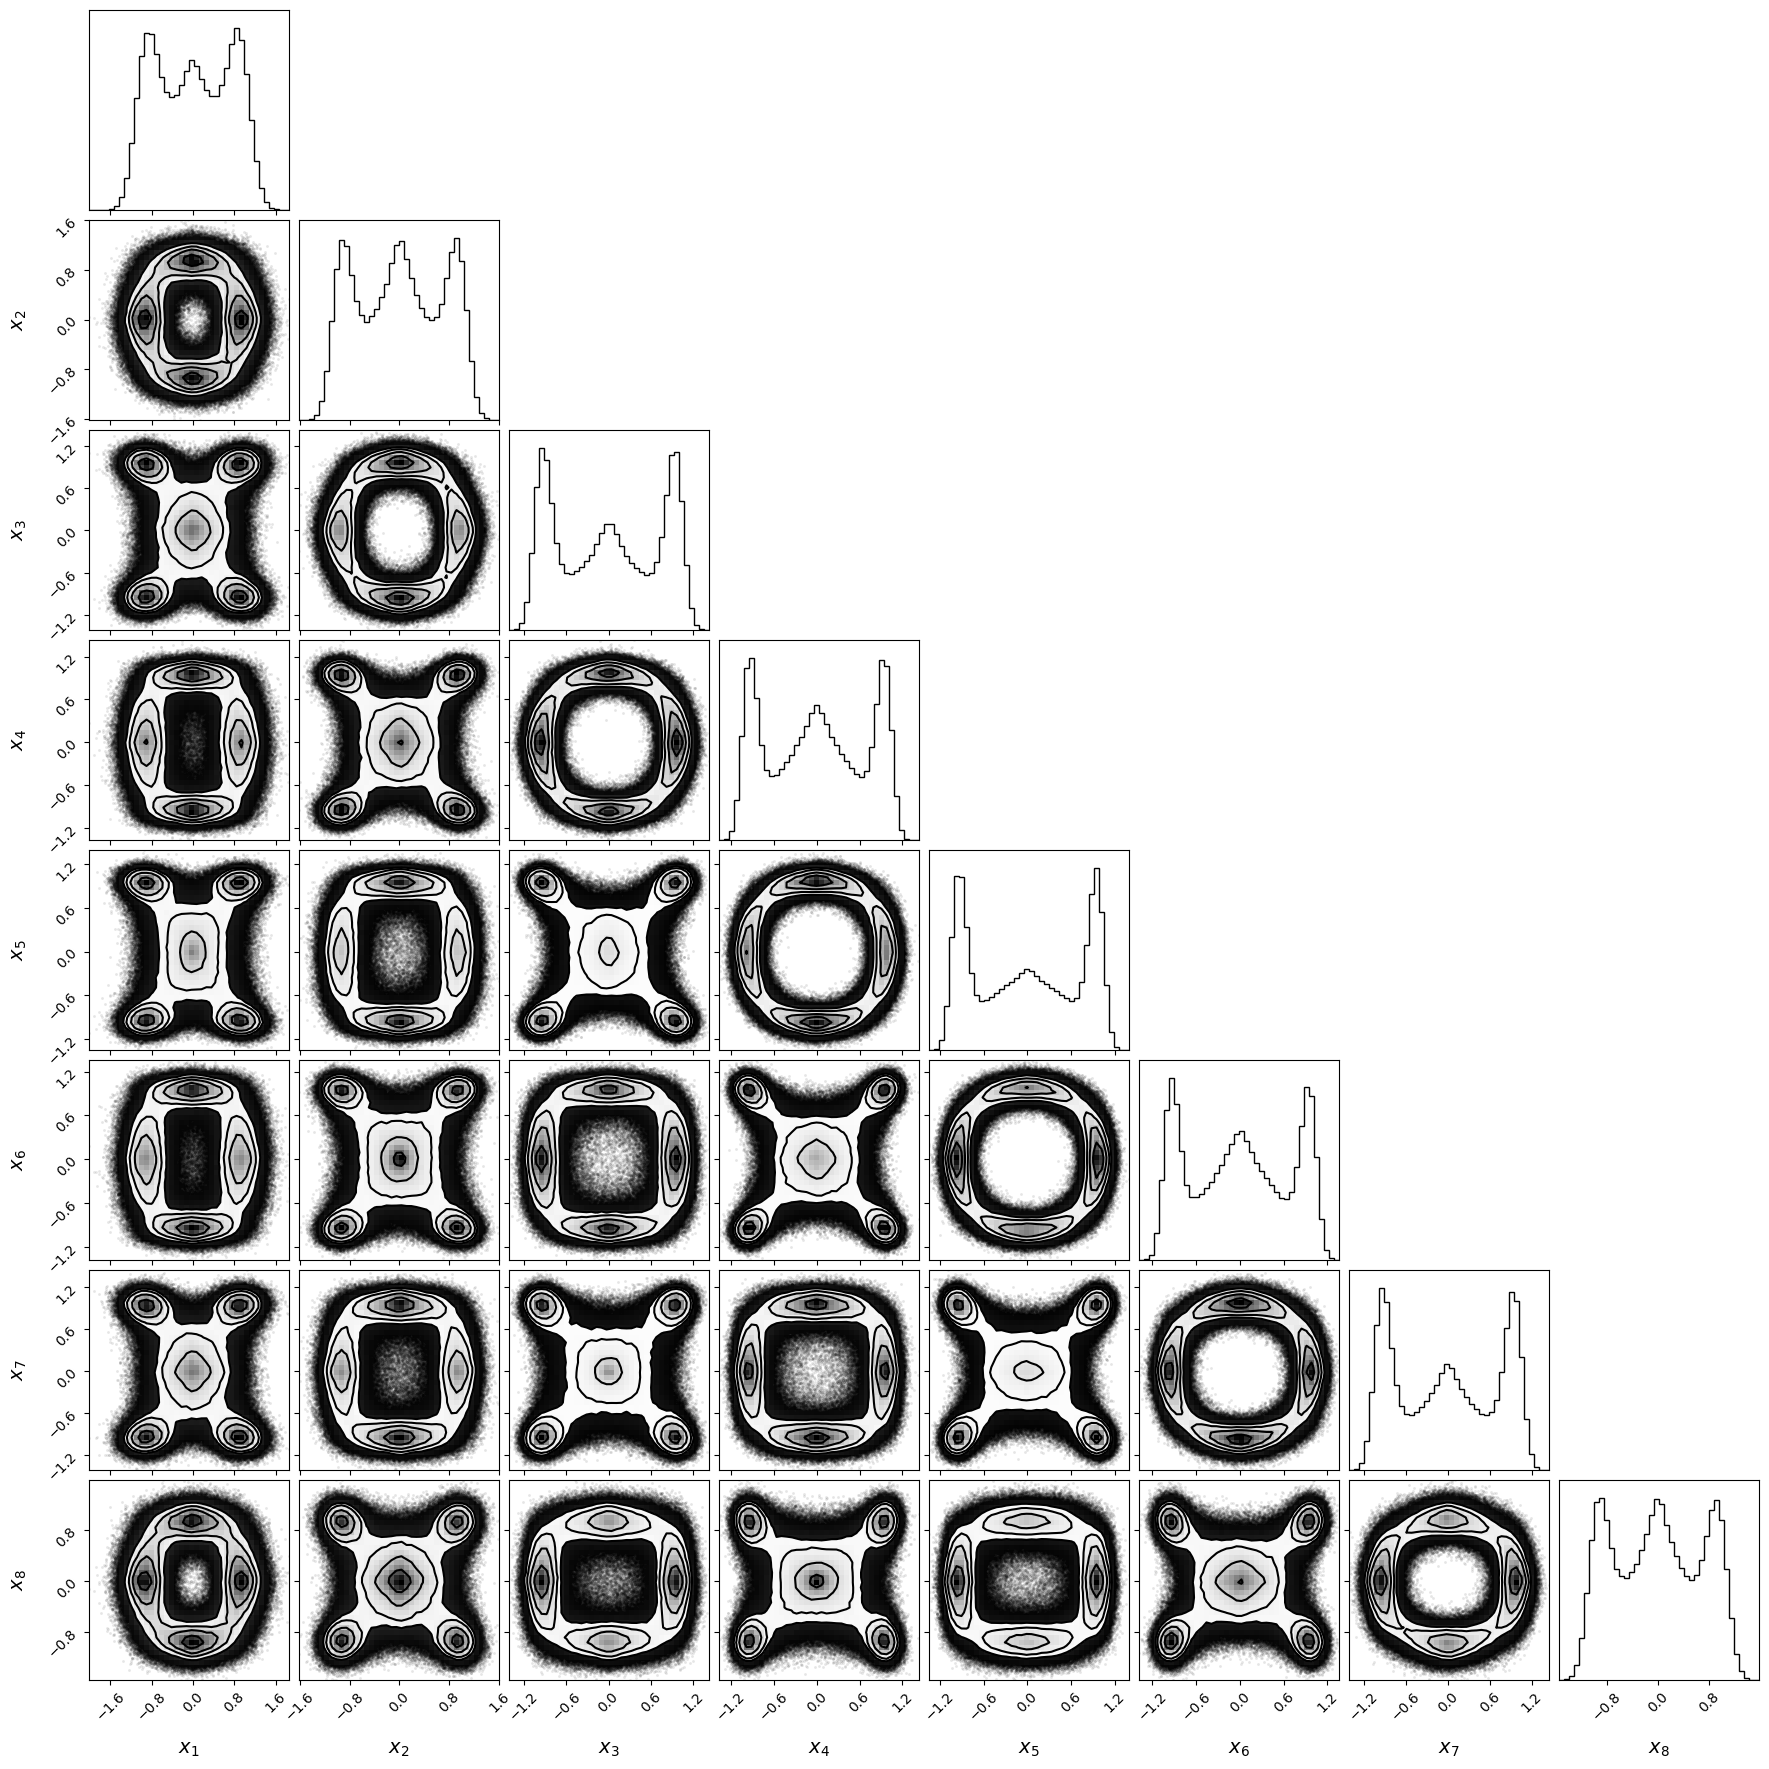

In [43]:
# plot distribution on low-level parameters
x_samples = np.array(samples['x'])
x_labels = np.array([rf'$x_{{{i}}}$' for i in range(1, ndim + 1)])
fig = corner.corner(x_samples,
                    labels=x_labels,
                    bins=40,
                    label_kwargs={'fontsize': 14})

In [44]:
# # plot distribution on hyper-parameters
# fig = corner.corner(np.array([samples['k'], samples['sigma']]).T,
#                     labels=[r'$k$', r'$\sigma$'],
#                     bins=40,
#                     range=[0.99]*2)